In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%pylab inline
import tensorflow_datasets as tfds
from nsec.datasets.massivenu import MassiveNu
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [4]:
from nsec.models.dae.convdae import SmallUResNet, UResNet
from jax.experimental import optix
import jax.numpy as jnp
from nsec.normalization import SNParamsTree as CustomSNParamsTree

In [5]:
import jax
import jax.numpy as jnp
import haiku as hk

import types
from typing import Mapping, Optional, Sequence, Union


class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

In [6]:
def forward(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

In [7]:

rng_seq = hk.PRNGSequence(42)
import jax 

In [8]:
# Saving params
import pickle

with open('lensing-conv-dae-noreg-2.pckl', 'rb') as file:
    params, state = pickle.load(file)

In [9]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [10]:
# Trying to sample from the model
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

In [11]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

def score_fn(x, sigma):
    return score(x.reshape((-1,320,320,1)), sigma.reshape((-1,1,1,1)), is_training=False)[0].reshape((-1, 320*320))

In [12]:
init_image=0.2*randn(1,320,320).reshape((-1, 320*320,)).astype('float32')

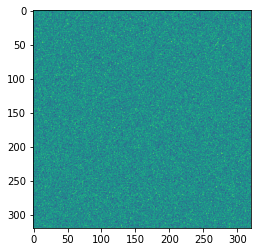

In [13]:
imshow(init_image[0].reshape((320,320)))

In [14]:
from nsec.tempered_sampling import TemperedMC

In [28]:
def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=0.0002,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=score_fn,
            inverse_temperatures=0.2*np.ones([1]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.9999,
            min_steps_per_temp=10,
            num_delta_logp_steps=4)

num_results = int(1e4)
num_burnin_steps = int(1)

samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_image,
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures),
        seed=jax.random.PRNGKey(0))

[Traced<ShapedArray(float32[1,102400]):JaxprTrace(level=1/0)>]


Text(0.5, 1.0, 'temp')

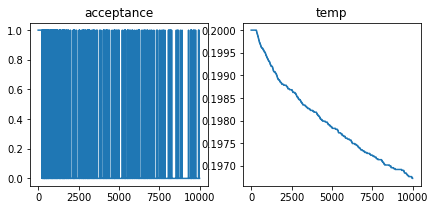

In [29]:
figure(figsize=(7,3))
subplot(121)
plot(trace[0]);
title('acceptance')
subplot(122)
plot(trace[1]);
title('temp')

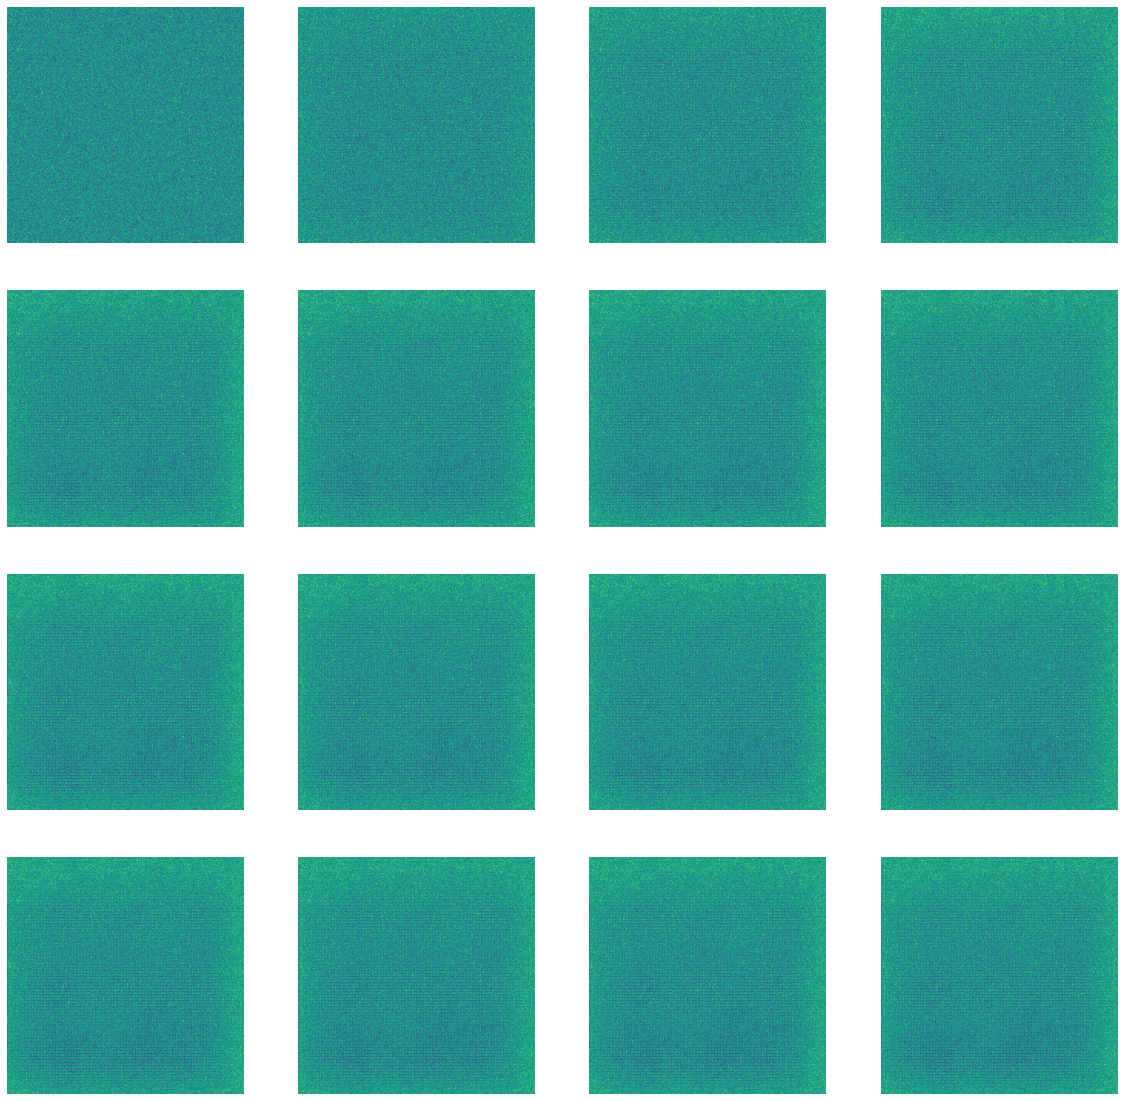

In [30]:
figure(figsize=(20,20))
for i in range(4):
  for j in range(4):
    subplot(4,4,4*i+j+1)
    imshow(samples[(4*i+j)*100,0].reshape((320,320)))
    axis('off')

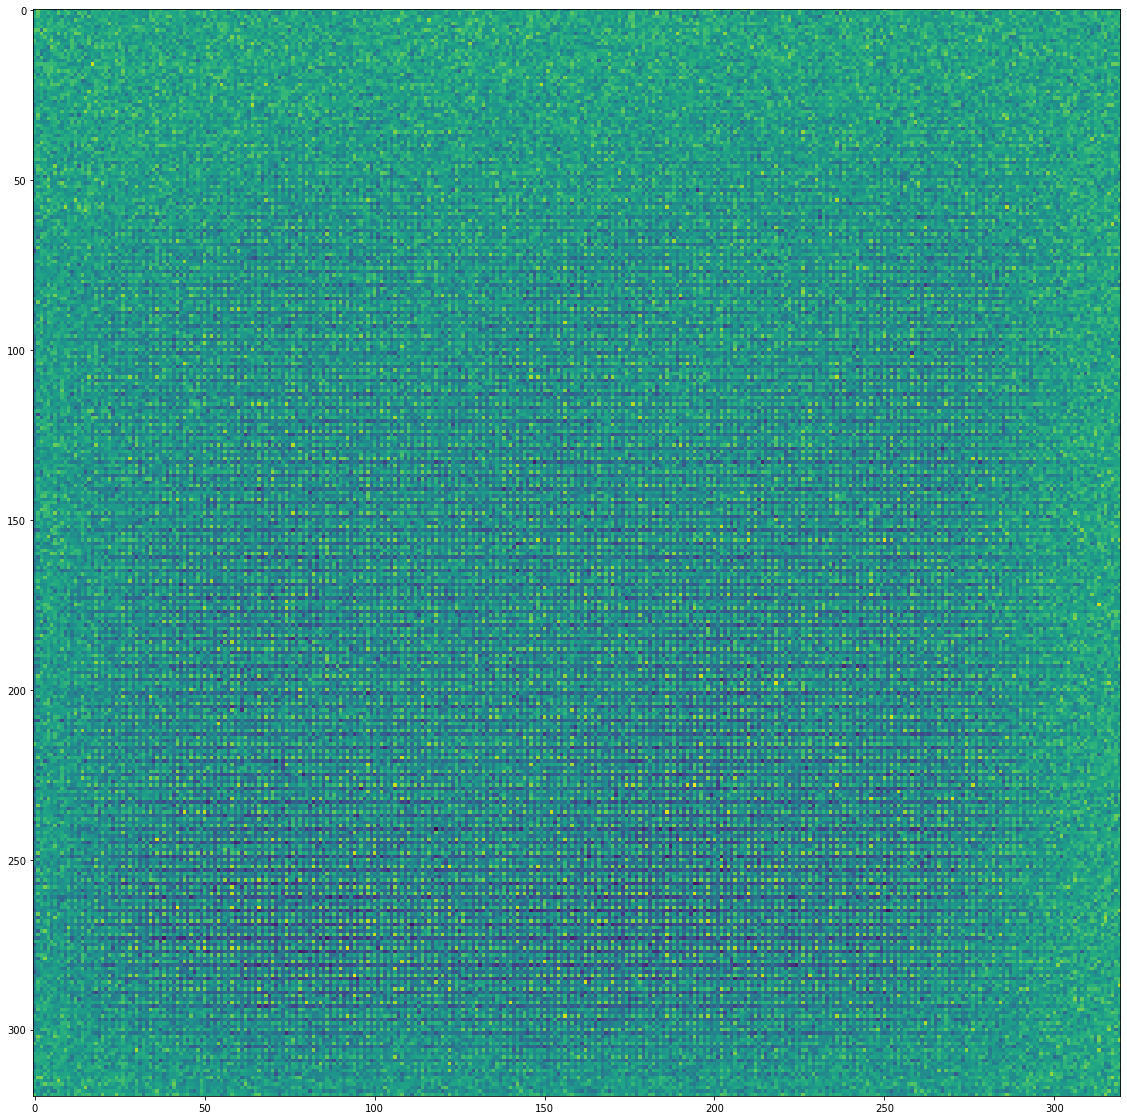

In [34]:
figure(figsize=(20,20))
imshow(samples[-1,0].reshape((320,320)));# colorbar()

In [18]:
delta=0.2

def preprocessing_fn(im):
    im = tf.image.random_crop(tf.expand_dims(im['map'],-1), [320,320,1])
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_flip_up_down(im)
    s = delta * tf.random.normal([1,1,1], mean=0.0, stddev=delta)
    u = tf.random.normal([320,320,1])
    x = im + s * u
    return {'x':x, 'y':im, 's':s, 'u':u}

dataset = tfds.load(name="massive_nu", split="train")
dataset = dataset.repeat()
dataset = dataset.map(preprocessing_fn)
dataset = dataset.shuffle(100)
dataset = dataset.batch(32)

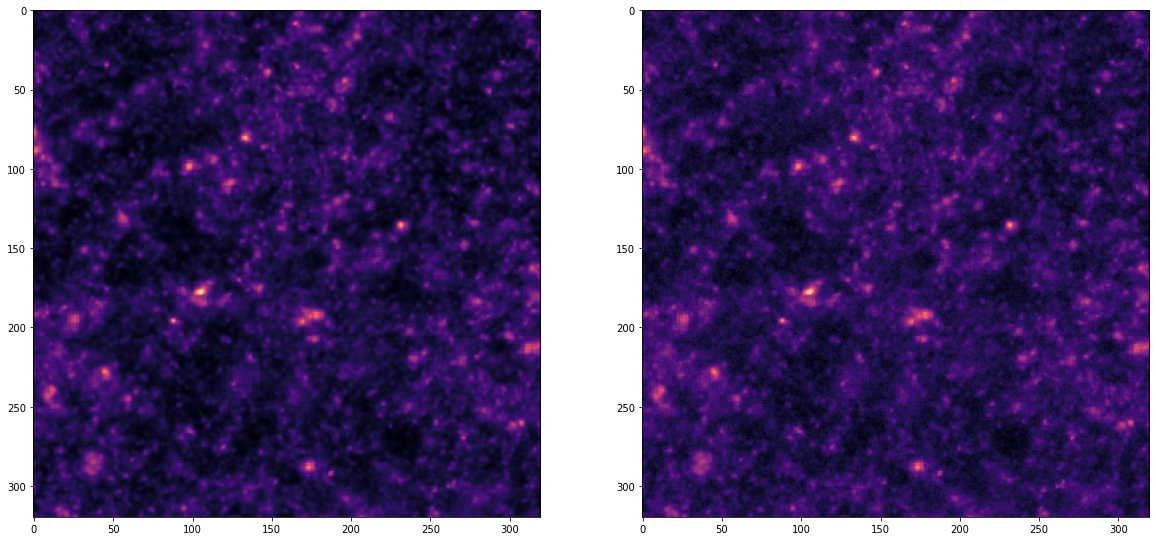

In [154]:
figure(figsize=(20,10))
for batch in dataset.take(1):  # Only take a single example
  subplot(121)
  imshow(batch['y'][0],cmap='magma')
  subplot(122)
  imshow(batch['x'][0],cmap='magma')

In [163]:
# Let's try an inpainting example
# Now implementing an inverse problem, for instance an inpainting and denoising problem  
import numpy as onp

m = onp.ones_like(batch['x'][0])
m[160-64:160+64, 160-64:160+64] = 0.
mask = jnp.array(m)

def likelihood_fn(x, sigma):
    """ This is a likelihood function for masked and noisy data
    """
    return jnp.sum(mask*((batch['x'][0].numpy() - x)/(batch['s'][0].numpy()+sigma))**2)/2.

score_likelihood = jax.vmap(jax.grad(likelihood_fn))

In [164]:
batch['s'][0].numpy()

array([[[0.00369334]]], dtype=float32)

(-0.5, 319.5, 319.5, -0.5)

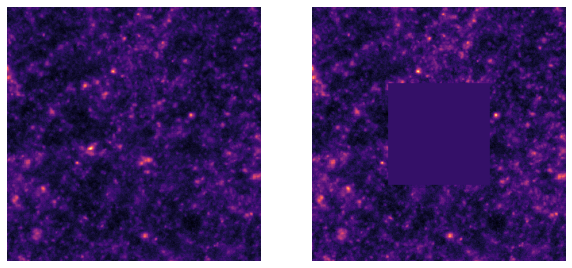

In [165]:
figure(figsize=(10,5))
subplot(121)
imshow(batch['x'][0,...,0].numpy().reshape((320,320)), cmap='magma'); axis('off')
subplot(122)
imshow((mask*batch['x'])[0,...,0].numpy().reshape((320,320)), cmap='magma'); axis('off')

In [185]:
# Adds the likelihood part to the score
def score_fn(x, sigma):
    return ( score(x.reshape((-1,320,320,1)), sigma.reshape((-1,1,1,1)), is_training=False)[0] + 
             - score_likelihood(x.reshape((-1,320,320,1)), sigma.reshape((-1,1,1,1)))
           ).reshape((-1, 320*320))

In [199]:
init_image=((mask*batch['x'])[0,...,0].numpy()+0.1*randn(1,320,320)).reshape((-1, 320*320,)).astype('float32')

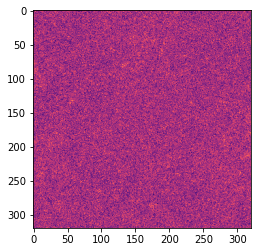

In [200]:
imshow(init_image.reshape((320,320)), cmap='magma')

In [ ]:
s0 =0.1
def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=0.001*(sigma/s0)**0.5,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=score_fn,
            inverse_temperatures=s0*np.ones([1]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.98,
            min_steps_per_temp=10,
            num_delta_logp_steps=4)

num_results = int(5e3)
num_burnin_steps = int(1)

samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_image,
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[Traced<ShapedArray(float32[1,102400]):JaxprTrace(level=1/0)>]


Text(0.5, 1.0, ' accept tempering')

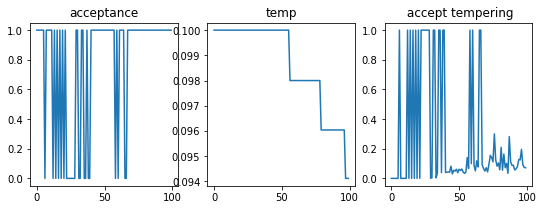

In [204]:
figure(figsize=(9,3))
subplot(131)
plot(trace[0]);
title('acceptance')
subplot(132)
plot(trace[1]);
title('temp')
subplot(133)
plot(clip(exp(trace[2]),0,1));
title(' accept tempering', )

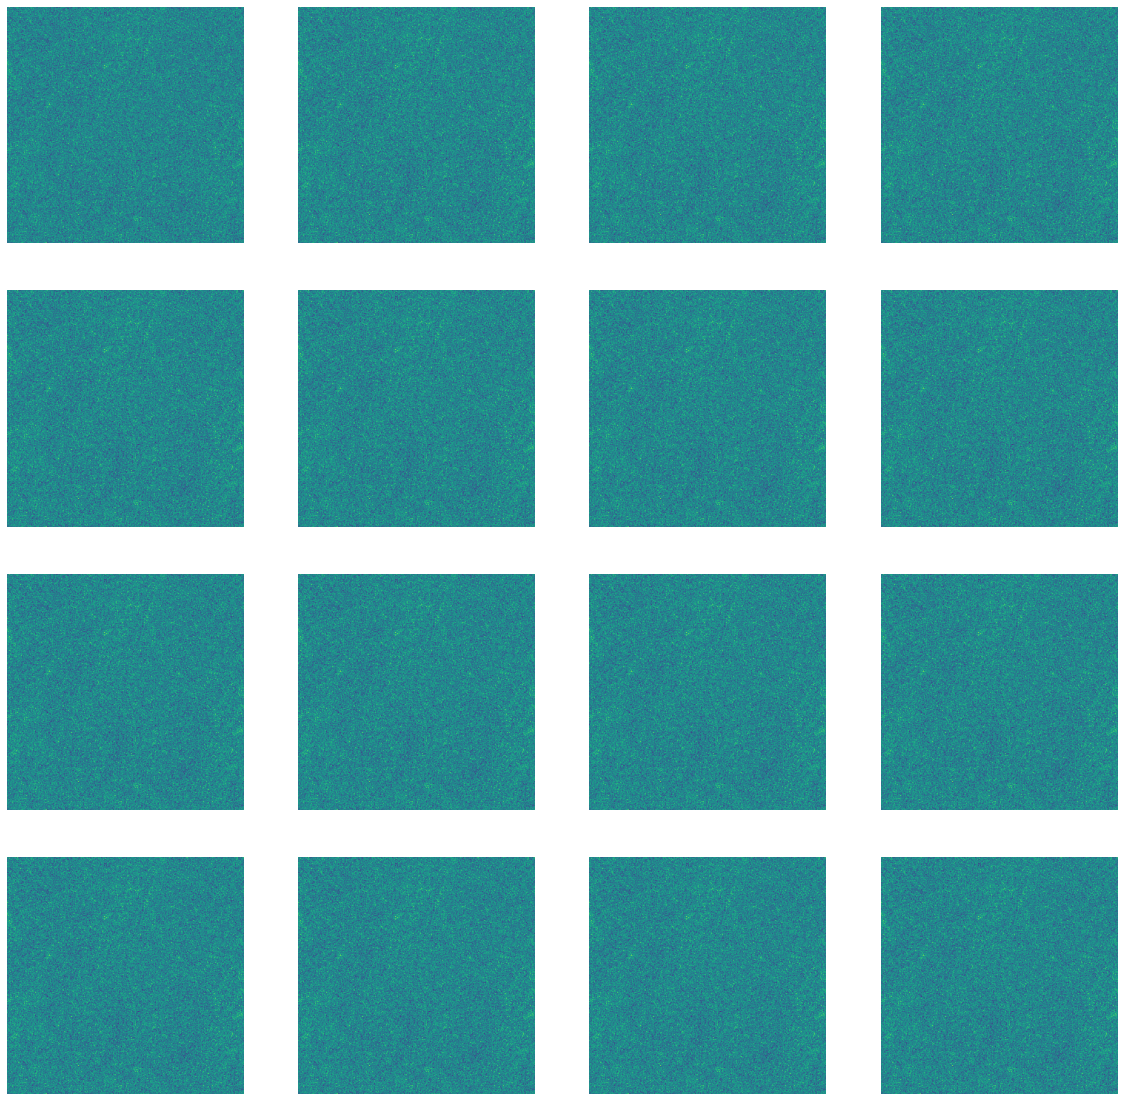

In [205]:
figure(figsize=(20,20))
for i in range(4):
  for j in range(4):
    subplot(4,4,4*i+j+1)
    imshow(samples[(4*i+j)*100,0].reshape((320,320)))
    axis('off')

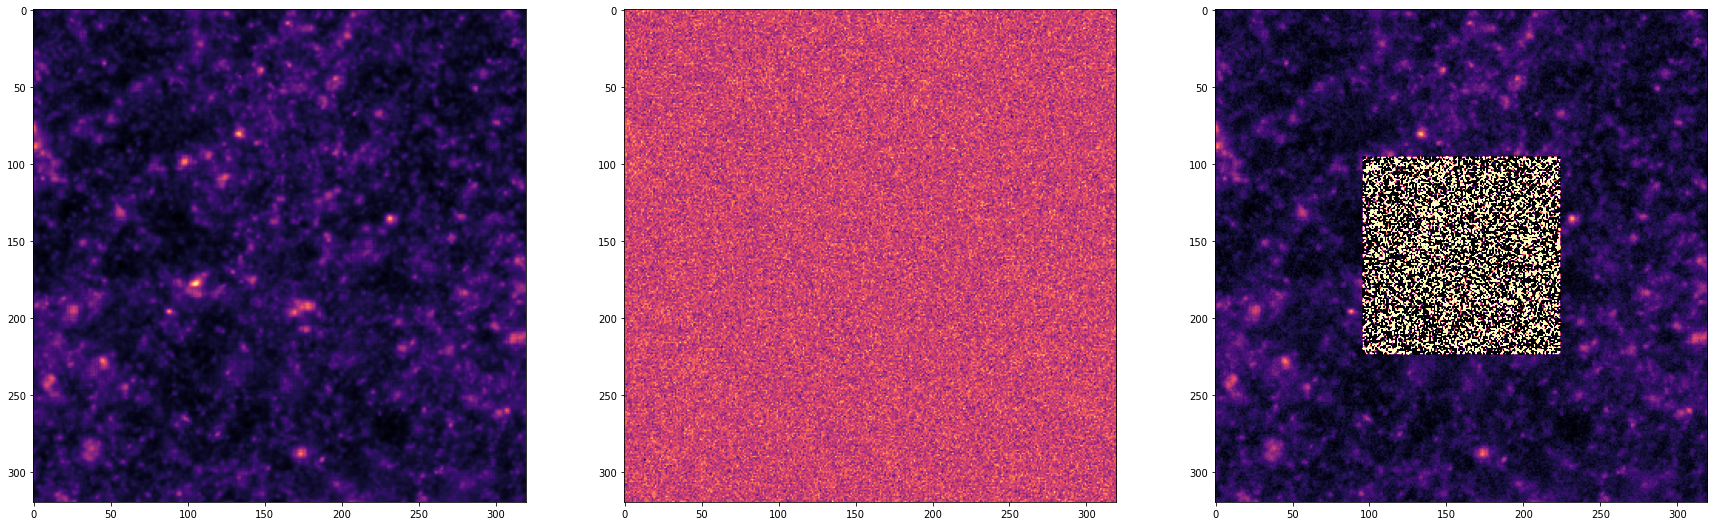

In [184]:
figure(figsize=(30,10))
subplot(131)
imshow(batch['y'][0],cmap='magma')
subplot(132)
imshow(init_image.reshape((320,320)),cmap='magma')
subplot(133)
imshow(samples[-1,0].reshape((320,320)),cmap='magma',
       vmin=batch['y'][0].numpy().min(), vmax=batch['y'][0].numpy().max())

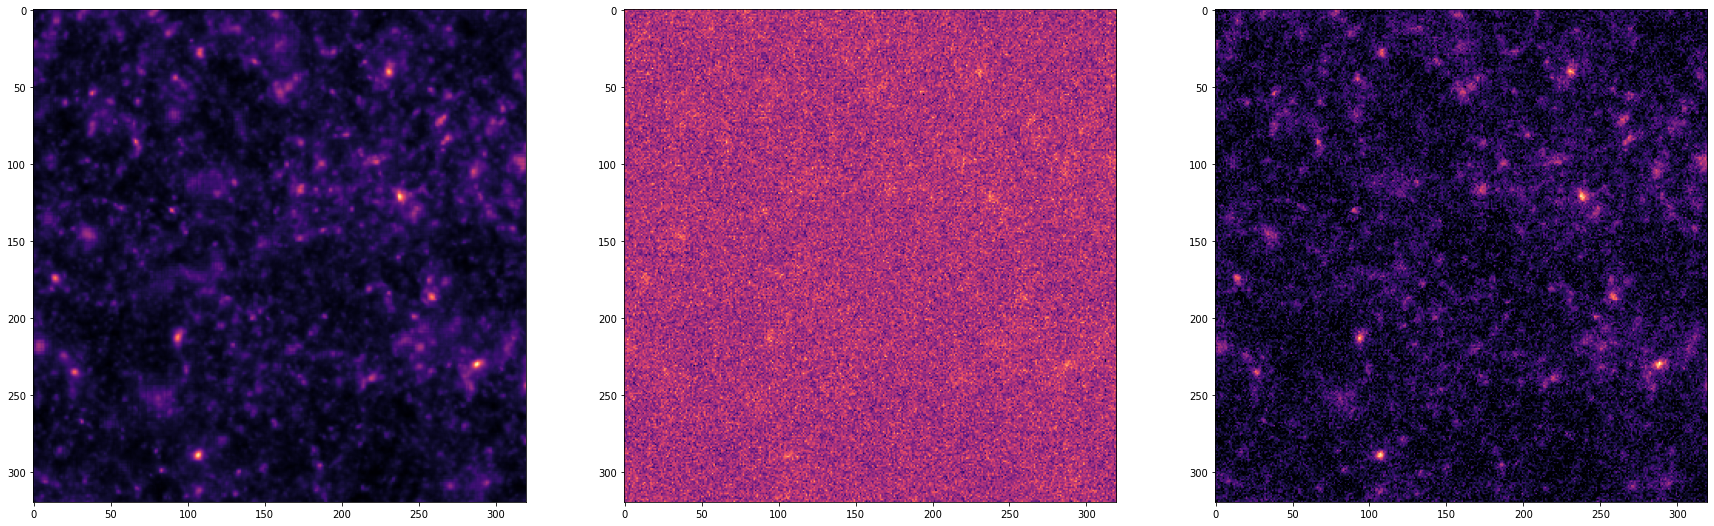

In [148]:
figure(figsize=(30,10))
subplot(131)
imshow(batch['y'][0],cmap='magma')
subplot(132)
imshow(init_image.reshape((320,320)),cmap='magma')
subplot(133)
imshow(samples[-1,0].reshape((320,320)),cmap='magma',
       vmin=batch['y'][0].numpy().min(), vmax=batch['y'][0].numpy().max())